In [1]:
import re
import nltk
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import spacy
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import warnings
from nltk.corpus import stopwords
warnings.filterwarnings("ignore",category=DeprecationWarning)
%matplotlib inline

#https://na80.lightning.force.com/lightning/r/Report/00O1P000003mYjbUAE/view

/Users/emeryames/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [10]:
def flatten(texts):
    return [word for sublist in texts for word in sublist]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]
stop_words = stopwords.words('english')

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [2]:
df = pd.read_csv('year_data.csv')
df.Description.head()

0    Chat transcript\n\n\n\t\n\t\t\n\t\t\tName: Jos...
1    Chat transcript\n\n\n\t\n\t\t\n\t\t\tE-mail: i...
2    Chat transcript\n\n\n\t\n\t\t\n\t\t\tName: Ant...
3    ---------- Forwarded message ---------\nFrom: ...
4    Chat transcript\n\n\n\t\n\t\t\n\t\t\tName: Mar...
Name: Description, dtype: object

In [36]:
data = df.Description.values.tolist()
data = [re.sub('\S*@\S*\s?', "", sent) for sent in data]
data = [re.sub('\s+', " ", sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub('https:\S+',"", sent) for sent in data]
data = [re.sub('Chat transcript',"", sent) for sent in data]
data = [re.sub('BevSpot Support here! How can we help',"", sent) for sent in data]
data = [re.sub('Chat has been opened from',"", sent) for sent in data]
data = [re.sub('E-mail', "", sent) for sent in data]
data = [re.sub('..:..:.. ..', "", sent) for sent in data]
data = [re.sub('America\S+', "", sent) for sent in data]
data = [re.sub('\S+.com\S+', "", sent) for sent in data]
data = [re.sub('BevSpot', "", sent) for sent in data]

data = [re.sub('invoices', "invoice", sent) for sent in data]
data = [re.sub('items', "item", sent) for sent in data]
data = [re.sub('reports', "report", sent) for sent in data]
data = [re.sub('orders', "order", sent) for sent in data]
data = [re.sub('recipes', "recipe", sent) for sent in data]


pprint(data[:1])

[' Name: Josh Taylor : Ryan Mon, 08/03/20   Hello. How may I help you? Josh '
 'Taylor  Hi Ryan, For the last few weeks, we have been waiting on a response '
 'in regards to pricing and recipe for large batches (frozen mixes) System  '
 'You were transferred to Bweir Bweir  Hi, Ryan. Id be happy to help. Let me '
 'look up your account. Ryan, you have a question about creating recipe? Or '
 'prep item? Josh Taylor  In tools we have drink pricing Is there a tool for '
 'pricing large gallon mixes to single serve 12oz drinks ? Bweir  Have you '
 'looked at the "create prepared item" tool? If you go to your Inventory '
 'History, and look at the top right, you can record a prepared item. You can '
 'add the ingredients and it will appear in your inventory. Then each time you '
 'prep the item you can record it and it will consume the ingredients. When '
 'you create a recipe, you can use that prepped item in your ingredients. You '
 'might also find this knowledge base article helpful:  4

In [37]:
data_words = list(sent_to_words(data))

In [11]:
names_lex = pd.read_csv('name_lexicon.csv')
names_list = names_lex.values.tolist()
names = remove_stopwords(names_list)
names = flatten(names)


['jim', 'hallers', 'matthew', 'robert', 'unknown', 'leathers', 'dee', 'clearslide', 'number', 'brad', 'mampe', 'john', 'shephard', 'radical', 'mampe', 'bertan', 'atac', 'ford', 'fry', 'chris', 'clyde', 'pat', 'brad', 'mampartner', 'christopher', 'lambing', 'melissa', 'drover', 'lela', 'cross', 'tim', 'gallant', 'wolfgang', 'schmitz', 'jason', 'icrave', 'jay', 'dunlea', 'bill', 'testaccount', 'renato', 'rodriguez', 'jon', 'grayem', 'mark', 'rupp', 'micaela', 'rene', 'kris', 'dizon', 'beau', 'black', 'david', 'jourdan', 'tabac', 'william', 'dissen', 'william', 'dissen', 'justin', 'hollis', 'marlon', 'hall', 'lisa', 'gerken', 'jerome', 'campbell', 'walker', 'langford', 'peter', 'golden', 'ryan', 'hill', 'kai', 'soderberg', 'clegg', 'ivey', 'joey', 'bien', 'damien', 'feno', 'ginger', 'castrios', 'fay', 'verkade', 'sean', 'rooney', 'roman', 'jacob', 'hanna', 'apollo', 'provided', 'rahiti', 'unknown', 'thomas', 'kaufman', 'frank', 'samperiz', 'aol', 'com', 'jerry', 'meltsner', 'joseph', 'sal

In [85]:
#updating stopwords

stop_words.extend (('chat','let','go','see','thank','get','done','email','take','look','hang','tight','show','reach','send','thanks',
                    'im','one','help','went','said','hi','gm','way','best','need','one','got','much','want','check','youll','sure',
                    'hello','hear','us','name','ok','okay','archived','yes','no','well','like','would','link','list','ill','ive',
                    'mon','tue','wed','thu','fri','gingrich','janeth','youre','th','jaycen','blendi','suvaria','great','says','set','ya',
                    'ocean','prime','roisman','casabona',
                    'erick','victoria','marguerite','dan'))
stop_words.extend(names)

#def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#    texts_out = []
#    for sent in texts:
#        doc = nlp(" ".join(sent)) 
#        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#    return texts_out

In [86]:
bigram = gensim.models.Phrases(data_words_nostops, min_count=2, threshold=1) #changed data_words to data_words_nostops
trigram = gensim.models.Phrases(bigram[data_words_nostops], threshold=1)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [87]:
data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

data_words_trigrams = make_trigrams(data_words_nostops)

#manually choose bigram or trigram


In [88]:
data = data_words_bigrams #edit for bi or tri
id2word = corpora.Dictionary(data)
texts = data
corpus = [id2word.doc2bow(text) for text in texts]

In [103]:
num_topics = 9
chunksize = 200 
passes = 30 
iterations = 1000
eval_every = 1 

lda_model = LdaModel(corpus=corpus,
    id2word=id2word,
    num_topics = num_topics, 
    random_state = 100,
    update_every = eval_every,
    chunksize=chunksize,
    eta = 'auto',
    passes = passes,
    iterations = iterations,
    alpha = 1,
    per_word_topics = True)
#score
print('\nPerplexity: ', lda_model.log_perplexity(corpus))
coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

#num = 8


Perplexity:  -7.59988189839526

Coherence Score:  0.3320091759221531


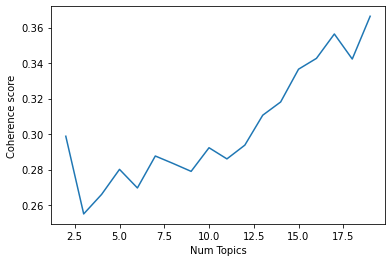

In [65]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus,
            id2word=id2word,
            num_topics = num_topics, 
            random_state = 100,
            update_every = eval_every,
            chunksize=chunksize,
            eta = 'auto',
            passes = passes,
            iterations = iterations,
            alpha = 1,
            per_word_topics = True)
        coherencemodel = CoherenceModel(model=model, texts=data, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data, start=2, limit=20, step=1)

# Elbow for best num_topics. 100% fucked until i figure it out
import matplotlib.pyplot as plt
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [104]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.065540  0.241795       1        1  20.203168
1      0.252732 -0.062750       2        1  17.581394
8      0.219657  0.121576       3        1  12.868703
7     -0.212956 -0.157311       4        1  11.817842
2     -0.103781  0.208713       5        1  10.554323
3      0.021406 -0.287078       6        1   9.663880
4     -0.263007  0.087610       7        1   7.661628
0      0.110796 -0.134660       8        1   7.245224
6     -0.090386 -0.017895       9        1   2.403839, topic_info=           Term        Freq       Total Category  logprob  loglift
18    inventory  140.000000  140.000000  Default  30.0000  30.0000
28       recipe   66.000000   66.000000  Default  29.0000  29.0000
43        count   55.000000   55.000000  Default  28.0000  28.0000
294      report  106.000000  106.000000  Default  27.0000  27.0000
55      account  210.000000  210.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1113   chatting   11.606296   33.501465   Topic9  -3.4432   2.6681
539      delray    2.477805    8.441232   Topic9  -4.9874   2.5023
446      update    4.375726   30.523731   Topic9  -4.4187   1.7857
490       happy    4.862248   40.926099   Topic9  -4.3132   1.5978
185     meeting    2.755033   12.737918   Topic9  -4.8813   2.1969

[540 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
190       1  0.264903             able
190       2  0.195192             able
190       3  0.195192             able
190       4  0.139423             able
190       5  0.181249             able
...     ...       ...              ...
172       2  0.088940             year
172       7  0.533639             year
262       6  0.905502              yep
262       7  0.100611              yep
1007      9  0.787142  yesterday_today

[911 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 9, 8, 3, 4, 5, 1, 7])